# Editing the data

Look through the data. Apply editing.

In [35]:
from kval.data import ctd
%matplotlib widget

In [36]:
cruise_ctd_id = 'fs2015_ctds'

### Load data

Load either from source cnvs or from pre-edited netCDF. 

In [52]:
load_from_cnvs = False
if load_from_cnvs:
    ds = ctd.ctds_from_cnv_dir('../../data/source/cnv/')
    ds = ctd.metadata_auto(ds)
else:
    ds = ctd.from_netcdf('../../data/intermediate/nc_initial/' + f'{cruise_ctd_id}_unprocessed.nc')

### Inspect the data 

Here: Look through the dataset to get a feel for the data and look for potential issues.

Useful functions:

```
ctd.map(ds)
ctd.contour(ds)
ctd.inspect_profiles(ds)
ctd.inspect_dual_sensors(ds)
```

### Edit outliers

Hand select outliers. 

To use the function, you have to choose the variable you want to edit (e.g. `TEMP1`) and the TIME index (# profile starting at 0). Use `ctd.inspect_profiles(ds)` to identify profiles that require editing. 

- Will make the points you remove `NaN`s.
- Will document in the metdata (`ds.PROCESSING` attributes) which points were removed.

___


- Select outliers by dragging a square around the point you want to select.
- You can select multiple squares.
- Zoom or move around in the plot by using the navigation icons that should appear on the left of side the plot if you hover your mouse over the figure.
    - To go back to selection mode, unselect the navigation icon you selected (e.g. click the "Zoom to rectangle icon" again).
- You can remove the selected points (`Remove selected` button) or forget the selection (`Forget selection`).

In [57]:
import importlib as imp
from kval.data.ship_ctd_tools import _ctd_edit
imp.reload(ctd)
imp.reload(_ctd_edit)

<module 'kval.data.ship_ctd_tools._ctd_edit' from '/home/oyvindl/work/code/python/kval/src/kval/data/ship_ctd_tools/_ctd_edit.py'>

Output()

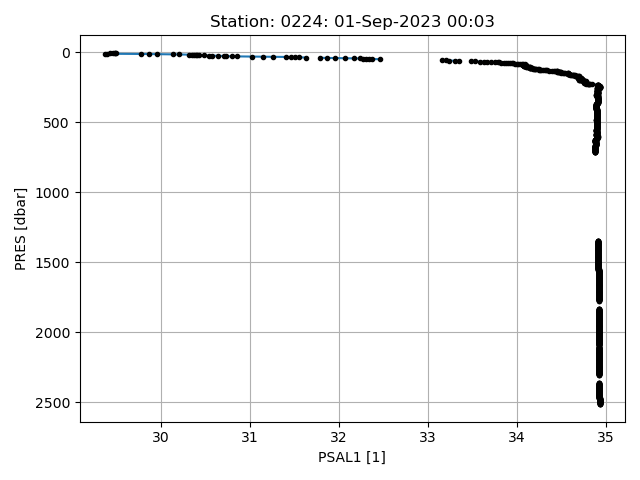

In [60]:
ds = ctd.hand_remove_points(ds, 'PSAL1', 2)

**Note**:
You can also do the same operation non-interactively, e.g.:
```
    # Remove (NaN out) PRES indixes [153, 154, 155, 156] from TIME index 2 (third profile) from PSAL1 
    ds = edit.remove_points_profile(ds, "PSAL1", 2, [153, 154, 155, 156])
```

##### Inspect metadata record

All operations affecting the data should leave a record in the file metadata. Speficially, we are storing information in the variable attributes of `ds.PROCESSING`:
 - `post_processing` is a human-readable algorithmic description.
 - `python_scipt` is a python script that can be used to reproduce the processing.

After any of the operations here, it is good to inspect `ds.PROCESSING` to see tat it correctly reflcts what we did.

> NOTE. The processing record is intended to make the post-processing **completely reproducible**. It can therefore become a bit bulky since we need to include e.g. every single point we hand edit out.

In [73]:
# ds.PROCESSING

### Apply threshold edit

Apply threshold editing; Only accept variables within a certain valid range.

Useful for e.g. removing a bunch of clearly non-physical outliers.

(The function plots a histogram of the variable data and lets you play around with the cutoffvalues before deciding to apply the threshold editing).  

> Note: After changing variables, you may have to press `Reset Sliders` to get to bars to start at max/min values)

- To apply a cut at the current cutoff values, press `Apply cut to ..`
- To save and exit, press `Exit`

In [40]:
ds = ctd.apply_threshold(ds)

**Note**:
You can also do the same operation non-interactively, e.g.:
```
    # Remove (Nan out) TEMP1 values below -2 or above 6.3
    ds = ctd.threshold(ds, variable='TEMP1', min_val=-2, max_val=6.3)
```

### Apply offset

Apply a numerical offset to a variable in the dataset - either to all or a single profile.

> Note: Auto-documentation id `ds.PROCESSING` currently only works for all profiles.

In [44]:
ds = ctd.apply_offset(ds)

RadioButtons(description='Apply offset to:', options=('TEMP1', 'TEMP2', 'CNDC1', 'CNDC2', 'DOXY1_instr', 'DOXY…

Output()

**Note**:
You can also do the same operation (for all profiles) non-interactively, e.g.:
```
    # Apply an offset of +2.2 to CNDC1
    ds = ctd.offset(ds, variable='CNDC1', offset=2.2)
```

### Apply chlorophyll calibrations

Apply chlorophyll calibration.

Do this if you have done a comparison between lab and CTD chlorophyll and extracted linear fit constants A and B to obtain calibrated chlorophyll `CHLA`:

    CHLA -> A * CHLA_fluorescence + B


- Assuming we have a field `CHLA_fluorescence` (or `CHLA1_fluorescence`) with uncalibrated fluorometer chlorophyll.
- Creates the new variable `CHLA`. Calibration coefficients A and B as well as other useful stuff in the metadata.
- Use the flag `remove_uncal=True` if you want to remove the old uncalibrated chlorophyll (`CHLA_fluorescence`)

In [ ]:
A = 1.1
B = 3.3

ds = ctd.calibrate_chl(ds, A = A, B = B) 

### Apply salinity calibration

No tailor-made function to do salinity correction yet.

Can use the more general functionality to apply a fixed offset to PSAL after salinometer comparison.

In [74]:
# Offset values based on salinity lab measurements (FAUX VALUES - UPDATE!!!!)
offsel_PSAL1 = 0.02
offsel_PSAL2 = -0.003


ds = ctd.offset(ds, variable='PSAL1', offset=offsel_PSAL1)
ds = ctd.offset(ds, variable='PSAL2', offset=offsel_PSAL2)

ds.PSAL1.attrs['comment'] = (f'A fixed offset {offsel_PSAL1} has been applied after'
                             ' comparison with laboratory measured salinity from bottle samples') 
ds.PSAL2.attrs['comment'] = (f'A fixed offset {offsel_PSAL2} has been applied after'
                             ' comparison with laboratory measured salinity from bottle samples') 

### Drop unwanted variables

Remove variables we don't want. For example, you may not need the `SBE_FLAG`, `TIME_SAMPLE` or `CRUISE` variables...

The function below allows us to manually select the variables we want to remove. 

In [72]:
ds = ctd.drop_vars_pick(ds)

HTML(value='Select variables to remove:')

Output()

**Note**:
You can also do the same operation non-interactively, e.g.:
```
    # Remove the variable SBE_FLAG from the dataset:
    ds = data.ctd.drop_variables(ds, drop_vars=['SBE_FLAG'])

### Save file

Saving the edited file to `data/intermediate/nc_edited/`.

We can always load the file and keep editing/changing it. 

Should in principle be pretty close to publishable if we have done all of the steps above, but we will still have to add soem custom metadata (and check everything thoroughly, of course). 



In [78]:
nc_edited_dir = '../../data/intermediate/nc_edited/'
ctd.to_netcdf(ds, nc_edited_dir, file_name = f'{cruise_ctd_id}_edited')

Updated history attribute. Current content:
---
2023-08-31 to 2023-09-12: Data collection.
2023-10-06: Processed to .cnv using SBE software (details in "PROCESSING.SBE_processing").
2024-08-12: Post-processing.
2024-08-12: Creation of this netcdf file.
---
Exported netCDF file as: ../../data/intermediate/nc_edited/fs2015_ctds_edited.nc


In [ ]:
ds_load = ctd.from_netcdf(nc_initial_dir + f'{cruise_ctd_id}_edited.nc')